$S$: Susceptibles

$I$: Infectives

$R$: Recovered with Immunity

$\beta$: Contact Rate

$\mu$: Average Death Rate

$B$: Average Birth Rate

$\frac{1}{\epsilon}$: Average Latent Period

$\frac{1}{\gamma}$: Average infectious period

$R_0$: Basic Reporoduction Number

$N$: Total Population


$$\frac{dS}{dt} = (1-ep) \mu N_{unvaccinated \ births} - \beta IS_{infections} - \mu S_{deaths}$$

$$\frac{dV}{dt} = ep \mu N_{vaccinated births} - \mu V_{deaths}$$

$$\frac{dI}{dt} = \beta IS_{infections} - \gamma I_{recoveries} - \mu I_{deaths}$$

$$\frac{dR}{dt} = \gamma I_{recoveries} - \mu R_{deaths}$$

where p is a fraction of the newly born individuals that are vaccinated at birth

the vaccination takes in a fraction e of the vaccinated individuals and protects them for an average period $\frac{1}{\omega}$ years

In [38]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

#Statistics from cia world factbook

e = .5
p = .75
mu = .00815
N = 321368864 #As of Jul 2015 estimate
beta = .75
gamma = .5

S0 = N
V0 = .5*N
I0 = .75*N
R0 = .25*N

#S[i] = (1-e*p)*mu*N - beta*I[i-1]*S[i-1] - mu*S[i-1]
#V[i] = e*p*mu*N - mu*V[i-1]
#I[i] = beta*I[i-1]*S[i-1] - gamma*I[i-1] - mu*I[i-1]
#R[i] = gamma*I[i-1] - mu*R[i-1]

In [39]:
def f(u):
    
    S = u[0]
    V = u[1]
    I = u[2]
    R = u[3]
    
    return numpy.array([(1-e*p)*mu*N - beta*I*S - mu*S,
                       e*p*mu*N - mu*V,
                       beta*I*S - gamma*I - mu*I,
                       gamma*I - mu*R])

In [40]:
def euler_step(u, f, dt):
    return u + dt * f(u)

In [41]:
T = 365
dt = 1
N = int(T/dt)+1
t = numpy.linspace(0, T, N)

u = numpy.zeros((N,4))
u[0] = [S0, V0, I0, R0]

for n in range(N-1):
    u[n+1] = euler_step(u[n], f, dt)
    


//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: overflow encountered in double_scalars
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


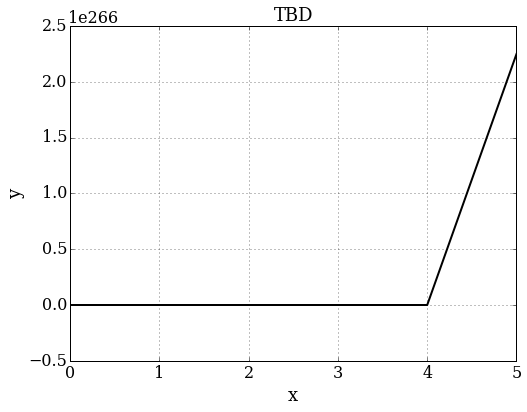

In [44]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'y', fontsize=18)
pyplot.title('TBD', fontsize=18)
pyplot.plot(t,u[:,0], 'k-', lw=2);
#pyplot.plot(t,u[:,1], 'k-', lw=2);
#pyplot.plot(t,u[:,1], 'k-', lw=2);
#pyplot.plot(t,u[:,1], 'k-', lw=2);